```
Problem Description : Predict the number of international airline passengers in units of 1,000

Data Description    : Data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Data Preparation

In [2]:
path = './airline-passengers.csv'

df = pd.read_csv(path)
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
data = df['Passengers']
data = data.values
data = np.array(data, np.float32)
data = data.reshape(-1, 1)

Visualize Time Series

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['Month'], df['Passengers'])
plt.xlabel('date')
plt.ylabel('num of passengers')
plt.title('Number of US Airline passengers from 1949 to 1960')
plt.show()

In [9]:
train_size = int(len(data) * 0.6)
val_size = test_size = int(len(data) * 0.2)

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

In [5]:
train_data.shape, val_data.shape, test_data.shape

((86,), (28,), (30,))

In [10]:
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

In [12]:
def gen_data(data, look_back=3):
    X = []
    Y = []
    
    for i in range(len(data)-look_back-1):
        X.append(data[i:i+look_back, 0])
        Y.append(data[i+look_back, 0])
    
    X = np.array(X)
    Y = np.array(Y)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    return X, Y

In [13]:
look_back = 3

X_train, y_train = gen_data(train_data, look_back)
X_val, y_val = gen_data(val_data, look_back)
X_test, y_test = gen_data(test_data, look_back)

In [14]:
from keras.layers import LSTM, GRU, Dense, InputLayer
from keras.models import Sequential

In [15]:
X_train.shape[1:]

(3, 1)

### LSTM

In [16]:
lstm = Sequential([
    InputLayer(input_shape=X_train.shape[1:]),
    LSTM(4, return_sequences=True, seed=42),
    LSTM(4, seed=42),
    Dense(1)
])

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 4)              96        
                                                                 
 lstm_1 (LSTM)               (None, 4)                 144       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

In [18]:
metrics = [
    MeanAbsoluteError(name='MAE'),
    RootMeanSquaredError(name='RMSE')
]

lstm.compile(optimizer='adam', loss='MeanSquaredError', metrics=metrics)

In [19]:
history = lstm.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
11/11 [==============================] - 4s 70ms/step - loss: 0.1699 - MAE: 0.3510 - RMSE: 0.4121 - val_loss: 0.8612 - val_MAE: 0.9085 - val_RMSE: 0.9280
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 0.1495 - MAE: 0.3235 - RMSE: 0.3866 - val_loss: 0.7958 - val_MAE: 0.8718 - val_RMSE: 0.8921
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1292 - MAE: 0.2950 - RMSE: 0.3595 - val_loss: 0.7278 - val_MAE: 0.8319 - val_RMSE: 0.8531
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1102 - MAE: 0.2670 - RMSE: 0.3320 - val_loss: 0.6579 - val_MAE: 0.7888 - val_RMSE: 0.8111
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0918 - MAE: 0.2385 - RMSE: 0.3029 - val_loss: 0.5887 - val_MAE: 0.7437 - val_RMSE: 0.7673
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0750 - MAE: 0.2136 - RMSE: 0.2738 - val_loss: 0.5193 - val_MAE: 0.6956 - val_RMSE: 0.7206
Epoc

In [21]:
train_history = lstm.evaluate(X_train, y_train)
print(f"Traning Loss [MSE] = {train_history[0]}")
print(f"Traning MAE = {train_history[1]}")
print(f"Traning RMSE = {train_history[2]}")

3/3 [==============================] - 1s 6ms/step - loss: 0.0137 - MAE: 0.0895 - RMSE: 0.1169
Traning Loss [MSE] = 0.013654813170433044
Traning MAE = 0.08954603224992752
Traning RMSE = 0.11685381084680557


In [22]:
val_history = lstm.evaluate(X_val, y_val)
print(f"Validation Loss [MSE] = {val_history[0]}")
print(f"Validation MAE = {val_history[1]}")
print(f"Validation RMSE = {val_history[2]}")

1/1 [==============================] - 0s 24ms/step - loss: 0.0586 - MAE: 0.1989 - RMSE: 0.2421
Validation Loss [MSE] = 0.05860775336623192
Validation MAE = 0.19888170063495636
Validation RMSE = 0.2420903742313385


In [23]:
test_history = lstm.evaluate(X_test, y_test)
print(f"Testing Loss [MSE] = {test_history[0]}")
print(f"Testing MAE = {test_history[1]}")
print(f"Testing RMSE = {test_history[2]}")

1/1 [==============================] - 0s 24ms/step - loss: 0.1877 - MAE: 0.3465 - RMSE: 0.4333
Testing Loss [MSE] = 0.18773606419563293
Testing MAE = 0.3464968800544739
Testing RMSE = 0.4332851767539978


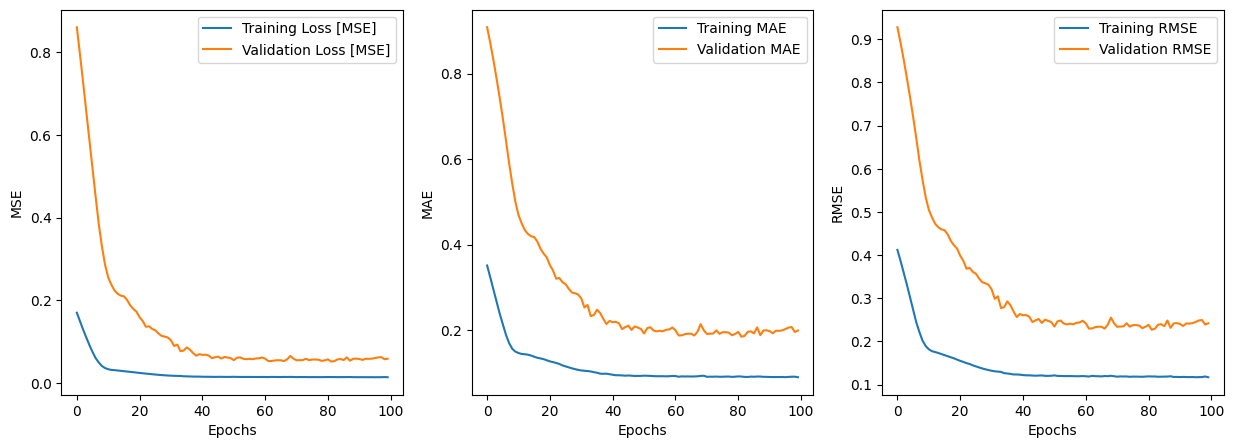

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss [MSE]')
plt.plot(history.history['val_loss'], label='Validation Loss [MSE]')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['MAE'], label='Training MAE')
plt.plot(history.history['val_MAE'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['RMSE'], label='Training RMSE')
plt.plot(history.history['val_RMSE'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

Predict

In [26]:
train_pred = lstm.predict(X_train)
val_pred = lstm.predict(X_val)
test_pred = lstm.predict(X_test)

# Invert Prediction
inv_train_pred = scaler.inverse_transform(train_pred)
inv_val_pred = scaler.inverse_transform(val_pred)
inv_test_pred = scaler.inverse_transform(test_pred)

inv_train_act = scaler.inverse_transform([y_train])
# inv_train_act = inv_train_act.reshape((inv_train_act.shape[1], inv_train_act[0]))

inv_val_act = scaler.inverse_transform([y_val])
# inv_val_act = inv_val_act.reshape((inv_val_act.shape[1], inv_val_act[0]))

inv_test_act = scaler.inverse_transform([y_test])
# inv_test_act = inv_test_act.reshape((inv_test_act.shape[1], inv_test_act[0]))

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 19ms/step


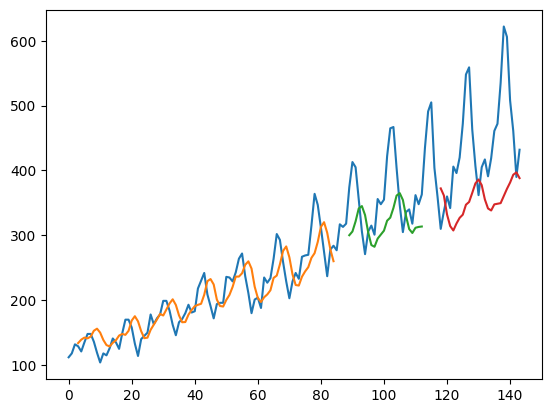

In [28]:
plot_train = np.empty_like(data)
plot_train[:, :] = np.nan
plot_train[look_back:len(inv_train_pred)+look_back, :] = inv_train_pred

plot_val = np.empty_like(data)
plot_val[:, :] = np.nan
start_val = len(inv_train_pred) + look_back*2 + 1
end_val = len(inv_train_pred) + len(inv_val_pred) + look_back*2 + 1
plot_val[start_val:end_val, :] = inv_val_pred

plot_test = np.empty_like(data)
plot_test[:, :] = np.nan
plot_test[len(data)-len(inv_test_pred):] = inv_test_pred

plt.plot(data)
plt.plot(plot_train)
plt.plot(plot_val)
plt.plot(plot_test)
plt.show()

### GRU

In [29]:
gru = Sequential([
    InputLayer(input_shape=X_train.shape[1:]),
    GRU(8, return_sequences=True, seed=42),
    GRU(8, seed=42),
    Dense(1)
])

gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 8)              264       
                                                                 
 gru_1 (GRU)                 (None, 8)                 432       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [31]:
gru.compile(optimizer='adam', loss='MeanSquaredError', metrics=metrics)

In [32]:
gru_history = gru.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
11/11 [==============================] - 3s 69ms/step - loss: 0.1261 - MAE: 0.3064 - RMSE: 0.3754 - val_loss: 0.5444 - val_MAE: 0.7150 - val_RMSE: 0.7379
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0643 - MAE: 0.1980 - RMSE: 0.2537 - val_loss: 0.3326 - val_MAE: 0.5477 - val_RMSE: 0.5767
Epoch 3/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0330 - MAE: 0.1415 - RMSE: 0.1817 - val_loss: 0.1944 - val_MAE: 0.4025 - val_RMSE: 0.4409
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0249 - MAE: 0.1300 - RMSE: 0.1578 - val_loss: 0.1435 - val_MAE: 0.3337 - val_RMSE: 0.3788
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0250 - MAE: 0.1328 - RMSE: 0.1582 - val_loss: 0.1306 - val_MAE: 0.3155 - val_RMSE: 0.3614
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0233 - MAE: 0.1269 - RMSE: 0.1525 - val_loss: 0.1406 - val_MAE: 0.3298 - val_RMSE: 0.3750
Epoc

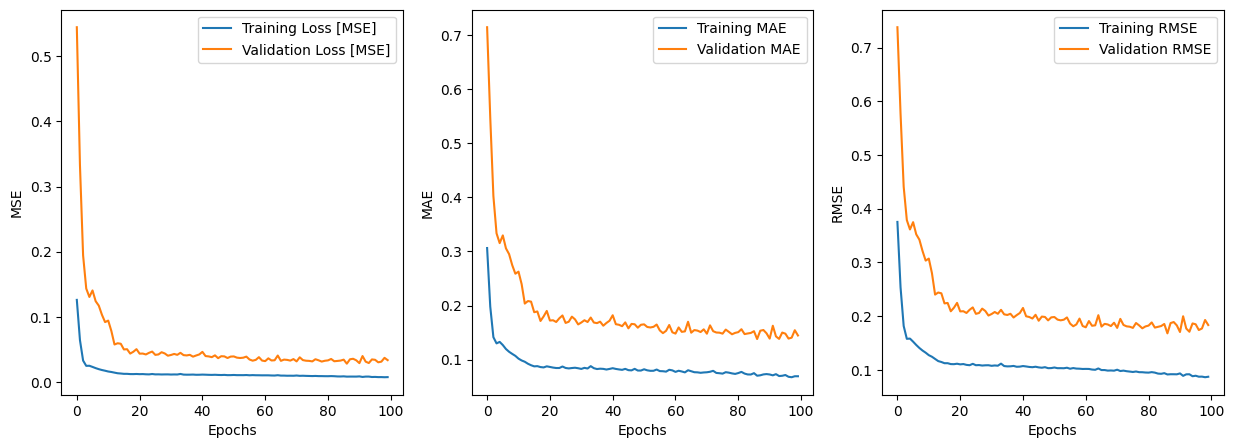

In [33]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(gru_history.history['loss'], label='Training Loss [MSE]')
plt.plot(gru_history.history['val_loss'], label='Validation Loss [MSE]')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(gru_history.history['MAE'], label='Training MAE')
plt.plot(gru_history.history['val_MAE'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(gru_history.history['RMSE'], label='Training RMSE')
plt.plot(gru_history.history['val_RMSE'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()